**Entraîner et de comparer plusieurs réseaux de neurones de type et de taille différent sur une tâche textuelle**, à savoir l'analyse de sentiment.


In [ ]:
# Installation de keras et de tensorflow (tensorflow étant une grosse bibliothèque, cela peut prendre un certain temps)
# Cette cellule n'a besoin d'être exécutée qu'une seule fois en tout et pour tout
!pip install keras Keras-Preprocessing tensorflow nltk

**Attention :** Après avoir exécuté la cellule ci-dessus, il faut impérativement redémarrer le noyau Python pour que Python puisse reconnaître le module nouvellement installé.

La manière de faire cela dépend de votre éditeur :

- Sur Jupyter : `Noyau -> Redémarrer` (ou `Kernel -> Restart` si l'instance est en anglais)
- Sur Colab : `Runtime -> Restart session` : <div><img src="img/colab.png" width="500"/></div>
- Sur VSCode : Un bouton `Restart`/`Redémarrer` : <div><img src="img/vscode.png" width="500"/></div>



In [ ]:
# Importation des bibliothèques:
# - random pour la génération de nombres aléatoires et la reproducibilité
# - numpy pour la gestion des matrices
# - tensorflow pour la gestion de réseaux de neuroens
# - keras pour la création et l'entraînement simplifié des réseaux (keras est une interface haut niveau qui utilise tensorflow)
# - pandas pour le chargement et la visualisation des données sous forme de tableau
# - scikit-learn, nltk et re pour le pré-traitement des données
# - matplotlib pour les graphiques

import random
import re
import numpy as np
import tensorflow as tf
import pandas as pd
import nltk
import keras

import matplotlib.pyplot as plt

from keras import Sequential
from keras.layers import Dense
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

# Reproducibilité
seed = 1

# Préparation des données

Le jeu de données sur lequel nous allons travailler est issu de [Kaggle](https://www.kaggle.com/datasets/abhi8923shriv/sentiment-analysis-dataset). Il s'agit d'un ensemble de tweets qui ont été automatiquement annoté pour de l'analyse de sentiment. Autrement dit, pour un tweet donné, on cherche à savoir si son contenu est positif, négatif ou neutre.

In [ ]:
# Chargement des données
df = pd.read_csv('data.csv',encoding='latin1')
df

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (KmÂ²),Density (P/KmÂ²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26
...,...,...,...,...,...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,night,31-45,Ghana,31072940,227540.0,137
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,morning,46-60,Greece,10423054,128900.0,81
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,noon,60-70,Grenada,112523,340.0,331
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,night,70-100,Guatemala,17915568,107160.0,167


Le jeu de données contient, en plus du tweet et de son étiquette (positif/négatif/neutre), beaucoup d'informations supplémentaires comme l'âge et le pays de l'utilisateur, ainsi que l'heure de la journée à laquelle le tweet a été écrit. Dans ce TP, nous n'utiliserons que le texte.

Notre but va être de prédire l'étiquette d'un tweet à partir de son texte. Il s'agit donc à nouveau d'un problème de **classification**.

Comme la dernière fois, la première étape consiste à transformer les étiquettes en probabilités. Nous avons à nouveau 3 types d'étiquettes possible, donc 3 probabilités pour chaque point de données.

In [ ]:
# On garde uniquement les deux colonnes qui nous intéressent, et on se débarrasse des lignes contenant des champs vides (N/A)
df = df[['text', 'sentiment']].dropna()

enc = OneHotEncoder(sparse_output=False)
labels = enc.fit_transform(df['sentiment'].values.reshape(-1, 1))
labels

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]])

Il nous faut désormais transformer le texte de chaque tweet en données numériques. Beaucoup d'approches sont possibles pour cela, dont en voici certaines :
- L'encodage 1 parmi n (vu précédemment), qui transforme chaque mot en une liste de zéros contenant un seul 1 à une position correspondant au mot
- La TF-IDF, qui transforme un texte en une liste de fréquences relatives de mots
- Les plongements sémantiques (*embedding*), qui transforme chaque mot du texte initial en une liste de nombres calibrée de manière à représenter le sens du mot

Nous allons dans un premier temps nous focaliser sur la TF-IDF.

# TF-IDF

La [TF-IDF](https://fr.wikipedia.org/wiki/TF-IDF) (term frequency/inverse document frequency) est une métrique qui associe à un document (texte) et à un mot donné un score d'importance compris entre 0 et 1. Nous ne nous attarderons pas sur sa formulation mathématique au cours de ce TP, mais elle utilise les principes suivants :
- Si un mot est fréquent dans un document mais dans peu d'autres documents, alors ce mot est spécifique à ce document et a un score élevé
- Si un mot est fréquent dans un grand nombre de documents, alors ce mot est commun et son score est plus faible.

La librairie `scikit-learn` contient un outil permettant de générer automatiquement la TF-IDF d'un ensemble de documents; elle s'occupe de diviser chaque document en mot, puis calcule le score de chaque mot.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorization = TfidfVectorizer()

# Calcule la TF-IDF de chaque mot dans chaque texte
tfidf = vectorization.fit_transform(df['text'])

La matrice `tfidf` contient désormais en position (i, j) la TF-IDF du mot numéro `j` dans le document numéro `i`.
Les numéros associés à chaque mot peuvent être lus en accèdant au dictionnaire `vectorization.vocabulary_`.

**À noter :** Par défault, `TfidfVectorizer` transforme tout le texte en minuscule et ignore une partie de la ponctuation.

Par exemple :

In [ ]:
num_doc = 1
print('Document :', df['text'][num_doc])

num_mot = vectorization.vocabulary_['in']
print('TF-IDF pour "in" :   ', tfidf[num_doc, num_mot])

num_mot = vectorization.vocabulary_['diego']
print('TF-IDF pour "diego" :', tfidf[num_doc, num_mot])

num_mot = vectorization.vocabulary_['dog']
print('TF-IDF pour "dog" :  ', tfidf[num_doc, num_mot])


Document :  Sooo SAD I will miss you here in San Diego!!!
TF-IDF pour "in" :    0.17777792095205294
TF-IDF pour "diego" : 0.5082417098880176
TF-IDF pour "dog" :   0.0


### Séparation et mélange

On rappelle qu'en apprentissage machine, il est important de séparer ses données en trois jeux :
- Le jeu d'entraînement, servant à entraîner les modèles,
- Le jeu de validation, qui sert à mesurer les performances des divers modèles que nous allons entraîner et à les comparer
- Le jeu de test, qui sert à mesurer les performances finales (vraies) du modèle retenu.

Nous pouvons réaliser la séparation grâce à la fonction `train_test_split`, comme au TP 1.

En général, on choisit de garder la majorité des données pour l'entraînement, et autant de données pour la validation que pour le test. Les ratios les plus couramment utilisés pour les trois jeux sont 60%-20%-20%, 80%-10%-10% et 90%-5%-5%.

In [ ]:
train_frac = 0.8
valid_frac = 0.1
test_frac = 0.1

# On sépare d'abord le jeu d'entraînement du reste
X_train, X_2, y_train, y_2 = train_test_split(tfidf, labels, test_size=valid_frac + test_frac, shuffle=True, random_state=seed)
# Puis on sépare le reste en deux (validation et test)
X_valid, X_test, y_valid, y_test = train_test_split(X_2, y_2, test_size=test_frac/(test_frac + valid_frac), shuffle=True, random_state=seed)

print(X_train.shape)
print(y_train.shape)

print(X_valid.shape)
print(y_valid.shape)

print(X_test.shape)
print(y_test.shape)

(21984, 26397)
(21984, 3)
(2748, 26397)
(2748, 3)
(2748, 26397)
(2748, 3)


Le nombre 26 397 correspond au nombre de mots uniques présents dans la matrice TF-IDF après la vectorisation des textes.

# Réseau de neurones

Comme au premier TP, nous allons commencer par créer un réseau de neurones à une couche (entrée -> sortie).

En plus de cela, notre réseau de neurones utilisera les éléments suivants :
- Fonction d'activation : Softmax (utilisée dans le cas d'une classification à plus de deux classes, alors que la sigmoïde est plutôt utilisée dans le cas à deux classes)
- Fonction de coût : Entropie croisée (utilisée en classification)

Enfin, pour effectuer la descente de gradient, diverses méthodes existent. La méthode que nous avons utilisée la dernière fois est la plus simple, mais elle n'est pas très efficace. Beaucoup d'autres méthodes plus complexes existent, faisant par exemple varier le taux d'apprentissage au cours du temps (*momentum*) ou en gardant en mémoire un taux d'apprentissage différent pour chaque poids du réseau, par exemple. La composante qui s'occupe de gérer cette partie s'appelle un *optimiseur*. Nous utiliserons ici l'optimiseur [Adam](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam).

Par chance, Keras rend l'implémentation de tout ceci extrêmement simple :

In [ ]:
# Reproducibilité
keras.utils.set_random_seed(seed)

# Création d'un réseau de neurones (liste de couches)
model = Sequential()

# Ajout d'une couche simple (dense), avec 3 sorties, et utilisant le Softmax comme fonction d'application
model.add(Dense(3, activation='softmax'))

# Finalise la création du modèle en utilisant l'entropie croisée pour fonction de coût, l'optimiseur Adam et en mesurant la précision du modèle à chaque époque
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entraîne le modèle pendant 30 itérations sur le jeu d'entraînement, et en mesurant la précision sur les jeux d'entraînement et de validation
# Cet étape prend une minute environ
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

# Affiche les couches du modèles et leur nombre de poids (paramètres)
model.summary()

Epoch 1/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4324 - loss: 1.0730 - val_accuracy: 0.4924 - val_loss: 1.0143
Epoch 2/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5379 - loss: 0.9856 - val_accuracy: 0.5797 - val_loss: 0.9592
Epoch 3/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6346 - loss: 0.9158 - val_accuracy: 0.6099 - val_loss: 0.9174
Epoch 4/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6881 - loss: 0.8586 - val_accuracy: 0.6328 - val_loss: 0.8850
Epoch 5/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7230 - loss: 0.8107 - val_accuracy: 0.6452 - val_loss: 0.8591
Epoch 6/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7469 - loss: 0.7699 - val_accuracy: 0.6565 - val_loss: 0.8381
Epoch 7/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7650 - loss: 0.7346 - val_accuracy: 0.6612 - val_loss: 0.8209
Epoch 8/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7801 - loss: 0.7035 - val_accuracy: 0.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (32, 3)                │        79,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 237,584 (928.07 KB)

 Trainable params: 79,194 (309.35 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 158,390 (618.71 KB)


On peut également facilement visualiser l'évolution de la précision au cours de l'entraînement :

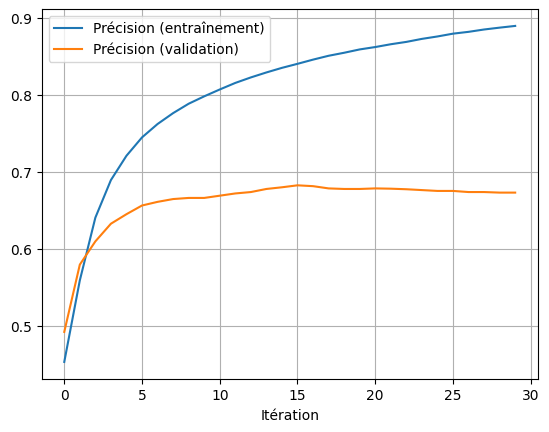

In [ ]:
def display_accuracy(history):
    plt.plot(history.history['accuracy'], label='Précision (entraînement)')
    plt.plot(history.history['val_accuracy'], label='Précision (validation)')
    plt.xlabel('Itération')
    plt.legend()
    plt.grid()
    plt.show()

display_accuracy(history)

On peut arrêter l'entraînement à partir de l'itération 10, la précision de validation se stabilise quand la précision d'entraînement continue d'augmenter, ce qui indique un surapprentissage.

# Utilisation du réseau

Faisons un test sur un exemple simple :

In [ ]:
ex_text = "The movie was so bad, I will not recommend this movie to anyone"

ex_tfidf = vectorization.transform([ex_text])
out = model(ex_tfidf.toarray())
out

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.71070164, 0.21318318, 0.0761151 ]], dtype=float32)>

Comment savoir quelle probabilité correspond à telle étiquette ? Nous pouvons regarder le contenu de l'encodeur 1 parmi n pour répondre à cette question :

In [ ]:
print(enc.inverse_transform([[1, 0, 0]]))
print(enc.inverse_transform([[0, 1, 0]]))
print(enc.inverse_transform([[0, 0, 1]]))

[['negative']]
[['neutral']]
[['positive']]


La première probabilité correspond donc à l'étiquette négative, la deuxième à la neutre et la dernière à la positive. Créons une fonction pour automatiser tout cela :

In [ ]:
def get_label(pos):
    label = [0, 0, 0]
    label[pos] = 1
    return enc.inverse_transform([label])[0][0]

def predict(ex_text, model, display=True):
    ex_tfidf = vectorization.transform([ex_text])
    out = model(ex_tfidf.toarray())
    out = out.numpy()
    sentiment = get_label(out.argmax())
    if display:
        return ex_text + ' -> ' + sentiment
    return sentiment

print(predict("I feel sad today", model))
print(predict("I love my mom", model))
print(predict("Today is Tuesday", model))
print(predict("Good riddance!", model))  # <- Erreur de classification

I feel sad today -> negative
I love my mom -> positive
Today is Tuesday -> neutral
Good riddance! -> positive


Comme ce réseau ne contient qu'une seule couche, on peut considérer qu'il attribue en fait un poids positif ou négatif à chaque mot du vocabulaire pour chaque étiquette possible, et qu'il calcule ensuite la somme des poids des mots contenus dans un texte, pondérés par la TF-IDF du mot donné.

On peut d'ailleurs observer ces poids directement dans le modèle :

In [ ]:
mot = "angry"
num_mot = vectorization.transform([mot]).argmax()
weights = model.layers[0].get_weights()[0][num_mot]
print(f"Poids pour le mot [{mot}]:")
for i, weight in enumerate(weights):
    print(f"{get_label(i):<10} {weight}")

Poids pour le mot [angry]:
negative   1.4262075424194336
neutral    -1.0276778936386108
positive   -2.008281707763672


# 2 couches et plus

Globalement, le modèle obtenu fonctionne plutôt bien. Cependant, le score de précision nous indique que près d'un tiers de ses prédictions sont erronnées. Nous aimerions l'améliorer, en lui permettant de faire des calculs plus complexes qu'une simple somme de poids. Pour cela, nous allons transformer notre perceptron en **perceptron multicouche** (MLP, *multilayer perceptron*). Il s'agit tout simplement de plusieurs perceptrons simples mis bout à bout :

<div><img src="img/mlp.png" width="500"/></div>

L'intérêt d'avoir plusieurs couches est que le réseau peut faire des opérations plus complexes : Si un simple perceptron à une couche lui permettait de faire une somme pondérée des scores des mots, ajouter une autre couche lui permet par exemple de calculer des sous-scores correspondant à certaines catégories de mots. D'ailleurs, un [théorème]([https://fr.wikipedia.org/wiki/Th%C3%A9or%C3%A8me_d%27approximation_universelle) dit qu'un réseau de neurones possédant deux couches suffisamment grandes (une couche cachée et une couche de sortie) est en théorie capable d'apprendre n'importe quelle fonction ! En pratique, les réseaux ont souvent plus de deux couches, mais qui sont moins grandes.

Savoir quelle fonction d'activation, combien de couches et quelle taille de couche utiliser est difficile; en pratique, même si quelques guides généraux existent, il s'agit surtout de tester différentes valeurs et de regarder ce qui marche le mieux...

On notera toutefois que pour les couches cachées, un principe général est d'utiliser une taille qui soit une puissance de 2 (2, 4, 8, 16, 32 etc. neurones).

Rajouter des couches se fait très simplement avec Keras, il suffit de définir leur fonction d'activation. Pour les couches intermédiaires d'un réseau de neurones, plusieurs fonctions d'activation existent, donc les plus courantes sont `relu`, `sigmoid` et `tanh`.

Un exemple à deux couches :

Epoch 1/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.3935 - loss: 1.0797 - val_accuracy: 0.4469 - val_loss: 1.0371
Epoch 2/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.4990 - loss: 1.0065 - val_accuracy: 0.5848 - val_loss: 0.9482
Epoch 3/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6609 - loss: 0.8867 - val_accuracy: 0.6412 - val_loss: 0.8509
Epoch 4/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7382 - loss: 0.7581 - val_accuracy: 0.6619 - val_loss: 0.7843
Epoch 5/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7760 - loss: 0.6552 - val_accuracy: 0.6754 - val_loss: 0.7458
Epoch 6/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8064 - loss: 0.5766 - val_accuracy: 0.6830 - val_loss: 0.7255
Epoch 7/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8301 - loss: 0.5148 - val_accuracy: 0.6852 - val_loss: 0.7166
Epoch 8/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8479 - loss: 0.4643 - val_accuracy: 0

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (32, 16)               │       422,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 3)                │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,267,259 (4.83 MB)

 Trainable params: 422,419 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 844,840 (3.22 MB)

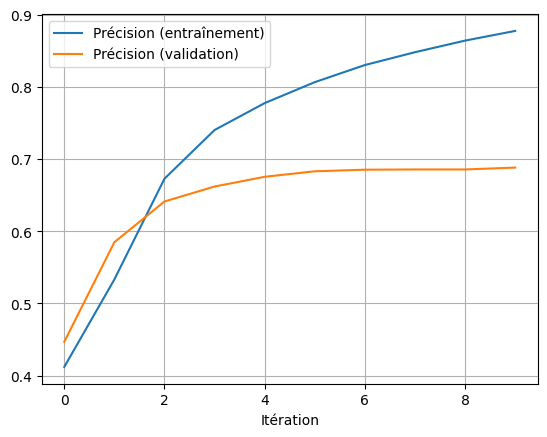

In [ ]:
keras.utils.set_random_seed(seed)
model2 = Sequential()

# Ajout d'une couche cachée avec 16 sorties, utilisant la fonction d'activation sigmoïde
model2.add(Dense(16, activation='sigmoid'))
# Ajout de la couche de sortie, avec 3 sorties, et utilisant le Softmax comme fonction d'application
model2.add(Dense(3, activation='softmax'))

# Entraînement et affichage
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model2.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
model2.summary()
display_accuracy(history)

In [ ]:
# Calcul de la précision sur le jeu de test
y_pred = model2(X_test.toarray()).numpy().argmax(axis=1)
y_true = y_test.argmax(axis=1)
print(f"Précision (test): {(y_pred == y_true).sum() / len(y_pred):.2%}")

Précision (test): 66.99%


**Attention :** On rappelle que bien que la précision globale soit une métrique utile, elle peut cacher des disparités entre les différentes classes. Selon les applications, il peut être préférable d'avoir un modèle qui soit globalement moins performant, mais qui soit aussi performant sur toutes les classes.

Observons donc la répartition des étiquettes dans le jeu de données :

<Axes: xlabel='sentiment'>

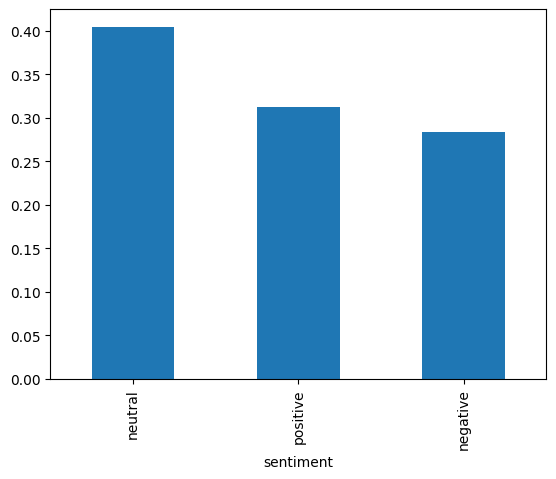

In [ ]:
df['sentiment'].value_counts(normalize=True).plot(kind='bar')

Ici, les trois classes sont représentées avec des proportions assez égales dans le jeu de données. Cependant, il peut être utile d'avoir d'observer à quel point celle-ci peut varier au sein des classes :

In [ ]:
print(classification_report(y_true, y_pred, target_names=[get_label(x) for x in range(3)]))

              precision    recall  f1-score   support

    negative       0.69      0.59      0.64       786
     neutral       0.60      0.72      0.65      1095
    positive       0.77      0.69      0.73       867

    accuracy                           0.67      2748
   macro avg       0.69      0.66      0.67      2748
weighted avg       0.68      0.67      0.67      2748



 0,77 pour la classe positive, 0,69 pour la classe négative et 0,60 pour la classe neutre.

### Taille du réseau

À la fin de l'entraînement, Keras affiche le nombre de paramètres que contient votre modèle, c'est-à-dire son nombre de poids et biais. Le modèle de la semaine dernière contenait un total de 12 poids (matrice de taille (3, 4)) et 3 biais, soit 15 paramètres. Ici, notre modèle à une couche contient 79 194 paramètres à entraîner (*trainable params*), il est donc beaucoup plus gros.
C'est souvent le cas pour les modèles travaillant sur du texte, qui ont besoin de beaucoup de poids pour être capable de modéliser un vocabulaire entier.

De plus, le nombre de paramètres d'un modèle augmente avec sa profondeur (nombre de couches). Les modèles de langue tels que celui utilisé par ChatGPT contiennent plusieurs milliards, voire dizaines de milliards de paramètres. Plus un modèle a de paramètres, plus l'entraîner ou l'utiliser prend de la mémoire et du temps.


Total params: 1,267,259 (4.83 MB)

## Analyse des résultats

Le modèle semble ne pas avoir d'amélioration significative, malgré l'ajout d'une couche supplémentaire. Observons quelques-unes des erreurs faites par le modèle :

In [ ]:
max_errors = 10
errors = 0
for idx, row in df.iterrows():
    pred = predict(row['text'], model, False)
    true = row['sentiment']
    if pred != true:
        print(f'Prédiction : [{pred}] au lieu de [{true}] pour le tweet [{row["text"]}]')
        errors += 1
        if errors >= max_errors:
            break

Prédiction : [neutral] au lieu de [negative] pour le tweet [my boss is bullying me...]
Prédiction : [negative] au lieu de [neutral] pour le tweet [Soooo high]
Prédiction : [neutral] au lieu de [negative] pour le tweet [Went to sleep and there is a power cut in Noida  Power back up not working too]
Prédiction : [neutral] au lieu de [positive] pour le tweet [I`m going home now. Have you seen my new twitter design? Quite....heavenly isn`****?]
Prédiction : [positive] au lieu de [negative] pour le tweet [i`m soooooo sleeeeepy!!! the last day o` school was today....sniffle....]
Prédiction : [neutral] au lieu de [negative] pour le tweet [ which case? I got a new one last week and I`m not thrilled at all with mine.]
Prédiction : [positive] au lieu de [neutral] pour le tweet [ what fun are you speaking of?]
Prédiction : [neutral] au lieu de [negative] pour le tweet [I give in to easily]
Prédiction : [positive] au lieu de [neutral] pour le tweet [ If you know such agent, do let me know]
Prédict

Les erreurs de classification peuvent être dues au manque de contexte et à l'ambiguïté des mots, liés à l'utilisation de TF-IDF.

Il est possible de visualiser les résultats du modèle grâce à une **matrice de confusion**. Il s'agit d'un tableau contenant en abscisse les étiquettes prédites par le modèle, et en ordonnée les étiquettes véritables. Chaque case contient alors le nombre d'exemples correspondant à une prédiction donnée :

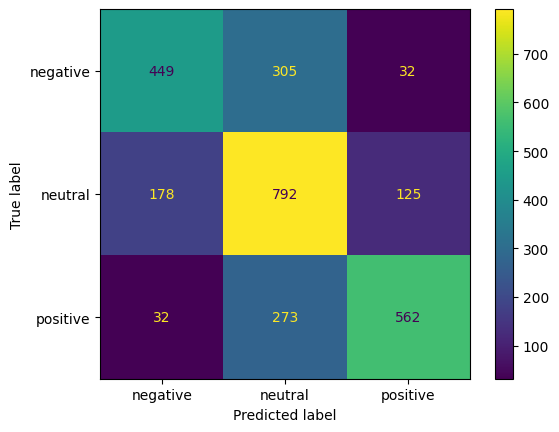

In [ ]:
y_pred = model(X_test.toarray()).numpy().argmax(axis=1)
y_true = y_test.argmax(axis=1)
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=[get_label(x) for x in range(3)])
plt.show()

Ici par exemple, la première rangée indique que 449 + 305 + 32 = 786 tweets étaient étiquetés comme négatifs dans le jeu de données. Sur ces 449, le modèle en a correctement étiqueté 449 comme négatifs, mais en a également étiqueté 305 comme neutres et 32 comme négatifs.

Similairement, la première colonne indique que sur 449 + 178 + 32 tweets que le modèle a décrit comme négatifs, seuls 449 étaient vraiment négatifs, 178 étaient en fait neutres, et 32 étaient positifs.

La jauge de couleur permet d'identifier facilement où sont les erreurs; dans l'idéal, la diagonale de la matrice de confusion doit être jaune, et le reste le plus violet possible. Ici, on remarque que le modèle a du mal à distinguer entre les tweets neutres et positifs/négatifs, mais qu'il étiquette très rarement un tweet négatif comme positif ou un positif comme négatif. D'autre part, la distinction entre un tweet négatif (ou positif) et un tweet neutre est assez floue et subjective. On peut donc imaginer que s'il n'y avait que ces deux types d'étiquettes, le modèle obtiendrait de meilleurs résultats.

# Bonus

## Partie 1 : Critiques de films (en français)

Le fichier `data_b.csv` contient un autre jeu de données, cette fois-ci composé de critiques de films enregistrées sur AlloCiné (en français). Au texte de chaque critique est associé un score de sentiment qui vaut soit 0 (critique négative), soit 1 (critique positive).


In [ ]:
# Lecture du fichier contenant les critiques de films... À vous d'écrire le reste !
df = pd.read_csv('data_b.csv')
df

,Unnamed: 0,film-url,review,polarity
0,0,http://www.allocine.fr/film/fichefilm-25385/cr...,"Magnifique épopée, une belle histoire, touchan...",1
1,1,http://www.allocine.fr/film/fichefilm-1954/cri...,Je n'ai pas aimé mais pourtant je lui mets 2 é...,0
2,2,http://www.allocine.fr/film/fichefilm-135523/c...,Un dessin animé qui brille par sa féerie et se...,1
3,3,http://www.allocine.fr/film/fichefilm-61514/cr...,"Si c'est là le renouveau du cinéma français, c...",0
4,4,http://www.allocine.fr/film/fichefilm-260395/c...,Et pourtant on s’en Doutait !Second volet très...,0
...,...,...,...,...
19995,19995,http://www.allocine.fr/film/fichefilm-59408/cr...,"je suis éventreur, arracheur, tailladeur, goug...",1
19996,19996,http://www.allocine.fr/film/fichefilm-141252/c...,Trémors 3 essouffle la série des trémors par u...,0
19997,19997,http://www.allocine.fr/film/fichefilm-48636/cr...,"0/20 : Tout d’abord, la mise en scène est tout...",0
19998,19998,http://www.allocine.fr/film/fichefilm-190157/c...,Un scénario très original mené par des personn...,1


(16000, 56977)
(16000, 2)
(2000, 56977)
(2000, 2)
(2000, 56977)
(2000, 2)
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.6103 - loss: 0.7211 - val_accuracy: 0.8670 - val_loss: 0.5851
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.9026 - loss: 0.5275 - val_accuracy: 0.8890 - val_loss: 0.3974
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.9321 - loss: 0.3263 - val_accuracy: 0.9065 - val_loss: 0.2880
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.9522 - loss: 0.2102 - val_accuracy: 0.9100 - val_loss: 0.2419
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9664 - loss: 0.1494 - val_accuracy: 0.9155 - val_loss: 0.2207
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9748 - loss: 0.1120 - val_accuracy: 0.9145 - val_loss: 0.2106
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9830 - loss: 0.0863 - val_accuracy: 0.9120 - val_loss: 0.2063
Epoch 8/10
500/5

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (32, 16)               │       911,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (32, 2)                │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,735,048 (10.43 MB)

 Trainable params: 911,682 (3.48 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,823,366 (6.96 MB)

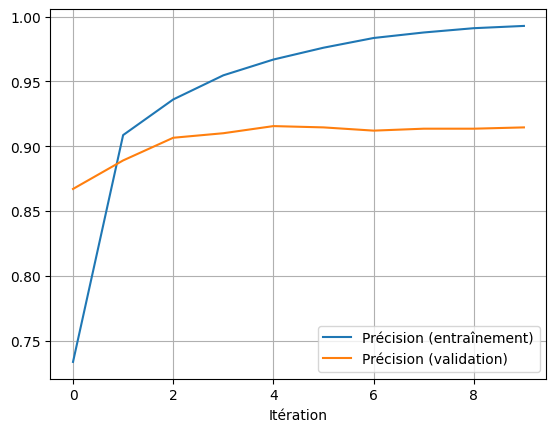

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Précision: 92.25%
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1052
           1       0.92      0.92      0.92       948

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



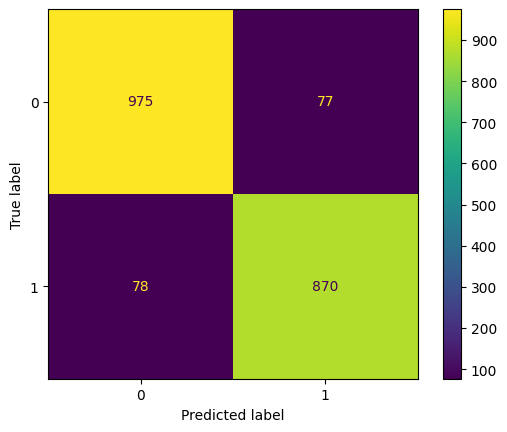

In [ ]:
# Seed
seed = 1

# On garde uniquement les deux colonnes qui nous intéressent, et on se débarrasse des lignes contenant des champs vides (N/A)
df = df[['review', 'polarity']].dropna()

# OneHotEncoder 0  1
enc = OneHotEncoder(sparse_output=False)
labels = enc.fit_transform(df[['polarity']])  # Use double brackets to keep it as a DataFrame

# Calcule la TF-IDF de chaque mot dans chaque texte
vectorization = TfidfVectorizer()
tfidf = vectorization.fit_transform(df['review'])

train_frac = 0.8
valid_frac = 0.1
test_frac = 0.1

# On sépare d'abord le jeu d'entraînement du reste
X_train, X_2, y_train, y_2 = train_test_split(tfidf, labels, test_size=valid_frac + test_frac, shuffle=True, random_state=seed)
# Puis on sépare le reste en deux (validation et test)
X_valid, X_test, y_valid, y_test = train_test_split(X_2, y_2, test_size=test_frac/(test_frac + valid_frac), shuffle=True, random_state=seed)

#datasets
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

def display_accuracy(history):
    plt.plot(history.history['accuracy'], label='Précision (entraînement)')
    plt.plot(history.history['val_accuracy'], label='Précision (validation)')
    plt.xlabel('Itération')
    plt.legend()
    plt.grid()
    plt.show()

# Création d'un réseau de neurones (liste de couches)
model3 = Sequential()
model3.add(Dense(16, activation='sigmoid')) # Ajout d'une couche cachée avec 16 sorties, utilisant la fonction d'activation sigmoïde
model3.add(Dense(2, activation='softmax')) # Ajout de la couche de sortie, avec 2 sorties (positive), et utilisant le Softmax comme fonction d'application

# Entraînement et affichage
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model3.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

# Summary, accuracy
model3.summary()
display_accuracy(history)

# Calcul de la précision sur le jeu de test
y_pred = model3.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)
print(f"Précision: {(y_pred == y_true).sum() / len(y_pred):.2%}")

#classification
print(classification_report(y_true, y_pred, target_names=enc.categories_[0].astype(str)))

#matrice de confusion
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=enc.categories_[0].astype(str))
plt.show()


## Partie 2 : Pré-traitement de texte avancé

La classe `TfidfVectorizer` a [beaucoup de paramètres optionnels](https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). En particulier, elle permet de pré-traiter et nettoyer le texte avant d'obtenir sa TF-IDF, avec par exemple :
- La suppression des accents et caractères spéciaux (paramètre `strip_accents`)
- Le passage du texte en minuscules (paramètre `lowercase`)
- La suppression des mots courants tels que "the", "and", etc. (paramètre `stop_words`)
- L'enregistrement d'expression multimots : plutôt que de calculer la TF-IDF pour les mots individuels, on peut également la calculer pour des suites (n-grams) de 2 ou plus mots consécutifs (on peut par exemple imaginer que le mot "very" soit neutre, mais que les expressions "very good" ou "very bad" soient de plus forts indicateurs que seulement "good" et "bad"). Ceci peut être contrôlé grâce au paramètre `ngram_range`. Attention, si vous modifiez ce paramètre, il est fortement conseillé d'également utiliser le paramètre `max_features` pour limiter la taille du dictionnaire à (par exemple) 30 000 mots ou suites de mots, ou vous risquez de manquer de mémoire.
- Le fait d'ignorer des mots trop rares ou trop fréquents (paramètres `min_df` et `max_df`)


(16000, 30000)
(16000, 2)
(2000, 30000)
(2000, 2)
(2000, 30000)
(2000, 2)
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.6952 - loss: 0.6457 - val_accuracy: 0.9065 - val_loss: 0.4737
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9263 - loss: 0.4050 - val_accuracy: 0.9190 - val_loss: 0.2976
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9491 - loss: 0.2355 - val_accuracy: 0.9295 - val_loss: 0.2255
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9681 - loss: 0.1547 - val_accuracy: 0.9325 - val_loss: 0.1946
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9801 - loss: 0.1088 - val_accuracy: 0.9320 - val_loss: 0.1801
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9869 - loss: 0.0786 - val_accuracy: 0.9315 - val_loss: 0.1737
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9916 - loss: 0.0573 - val_accuracy: 0.9310 - val_loss: 0.1720
Epoch 8/10
500/500 ━━━

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (32, 16)               │       480,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (32, 2)                │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,440,152 (5.49 MB)

 Trainable params: 480,050 (1.83 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 960,102 (3.66 MB)

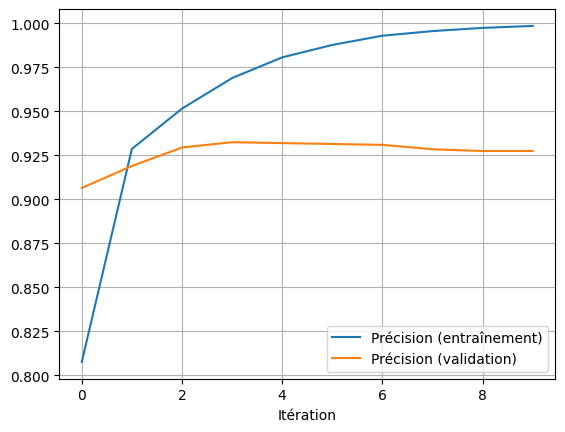

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Précision: 93.35%
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1052
           1       0.93      0.93      0.93       948

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



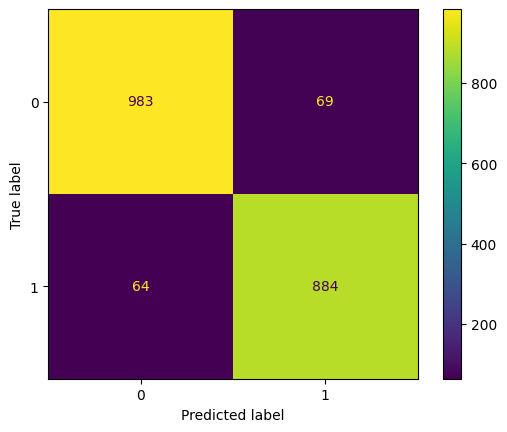

In [ ]:
# Seed
seed = 1

# On garde uniquement les deux colonnes qui nous intéressent, et on se débarrasse des lignes contenant des champs vides (N/A)
df = df[['review', 'polarity']].dropna()

# OneHotEncoder 0  1
enc = OneHotEncoder(sparse_output=False)
labels = enc.fit_transform(df[['polarity']])  # Use double brackets to keep it as a DataFrame

# Vector TF-IDF
vectorization = TfidfVectorizer(
    strip_accents='unicode',  # Suppression des accents
    lowercase=True,           # Passage en minuscules
    stop_words='english',      # Suppression des mots courants
    ngram_range=(1, 2),      # Utilisation des unigrams et bigrams
    max_features=30000,      # Limitation de la taille du dictionnaire
    min_df=2,                # Ignorer les mots trop rares
    max_df=0.95              # Ignorer les mots trop fréquents
)
tfidf = vectorization.fit_transform(df['review'])

train_frac = 0.8
valid_frac = 0.1
test_frac = 0.1

# On sépare d'abord le jeu d'entraînement du reste
X_train, X_2, y_train, y_2 = train_test_split(tfidf, labels, test_size=valid_frac + test_frac, shuffle=True, random_state=seed)
# Puis on sépare le reste en deux (validation et test)
X_valid, X_test, y_valid, y_test = train_test_split(X_2, y_2, test_size=test_frac/(test_frac + valid_frac), shuffle=True, random_state=seed)

#datasets
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

def display_accuracy(history):
    plt.plot(history.history['accuracy'], label='Précision (entraînement)')
    plt.plot(history.history['val_accuracy'], label='Précision (validation)')
    plt.xlabel('Itération')
    plt.legend()
    plt.grid()
    plt.show()

# Création d'un réseau de neurones (liste de couches)
model4 = Sequential()
model4.add(Dense(16, activation='sigmoid')) # Ajout d'une couche cachée avec 16 sorties, utilisant la fonction d'activation sigmoïde
model4.add(Dense(2, activation='softmax')) # Ajout de la couche de sortie, avec 2 sorties (positive), et utilisant le Softmax comme fonction d'application

# Entraînement et affichage
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model4.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

# Summary, accuracy
model4.summary()
display_accuracy(history)

# Calcul de la précision sur le jeu de test
y_pred = model4.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)
print(f"Précision: {(y_pred == y_true).sum() / len(y_pred):.2%}")

#classification
print(classification_report(y_true, y_pred, target_names=enc.categories_[0].astype(str)))

#matrice de confusion
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=enc.categories_[0].astype(str))
plt.show()
